In [1]:
%matplotlib inline
from genshintoolkit.gtcommon.gtenum import *
from genshintoolkit.gtcommon.atfdata import *
from genshintoolkit.gtcommon.reaction import reaction_catalyze
import numpy as np
from matplotlib import pyplot as plt
from genshintoolkit.gtcommon import factors

In [2]:
# consts
multiplier_e=[
    ('atk',1.858),
    ('em',3.715),
]

dmgb_e=lambda em:(em-200)*0.001 if 200<=em<=1000 else (0.8 if em>1000 else 0)
cr_e=lambda em:(em-200)*0.0003 if 200<=em<=1000 else (0.24 if em>1000 else 0)

baseatk_nahida=299
em_nahida=115
em_nahida_acc=lambda em: min(200,0.2*em)

em_weapon1=265
baseatk_weapon1=542

em_weapon1_effect1=lambda charcount_same:charcount_same*32
em_weapon1_effect2=40
dmgb_weapon1_effect=lambda charcount_diff: charcount_diff*0.1

em_glidedreams_2pcs=80
em_glidedreams_4pcs=lambda char_diff: min(char_diff,3)*50
atkp_glidedreams_4pcs=lambda char_same: min(char_same,3)*0.14


In [3]:
# config 1: sub DPS

In [4]:
def calc(atkp=0,em=0,cr=0,cd=0,grass_globlet=True):
    factor_def_res=factors.defense()*factors.resistence(0.5)
    atk=(baseatk_nahida+baseatk_weapon1)*(1+atkp)+311
    em+=em_nahida_acc(em)
    cr_bonus=cr_e(em)
    crit=0.05+cr+0.311
    cdmg=0.5+cd

    while(crit>1):
        crit-=0.033
        cdmg+=0.066

    basedmg=atk*1.858+em*3.175+reaction_catalyze(EnumCatalyzeReaction.spread,em)*0.5

    return basedmg*\
            (1+
                (0.466 if grass_globlet else 0)+
                dmgb_e(em)+
                dmgb_weapon1_effect(3))*\
            factors.critical(crit,cdmg)*\
            factor_def_res,\
            atk,em,crit,cdmg


In [5]:
from genshintoolkit.math_tools import get_point_distribution
from genshintoolkit.gtcommon.atfdata import substat_values_avg

distr=get_point_distribution(35,4)
max=[None,None]
for i in distr:
    atk,em,cr,cd=i
    if cr<30 and cd+cr<=35 and em<=30:
        result=calc(
            substat_values_avg[EnumStats.atk_percent]*atk+
                atkp_glidedreams_4pcs(1),
            substat_values_avg[EnumStats.em]*em+em_nahida+
                em_weapon1+em_weapon1_effect1(1)+
                em_weapon1_effect2+
                em_glidedreams_2pcs+
                em_glidedreams_4pcs(2)+100+187,
            substat_values_avg[EnumStats.crit_rate]*cr,
            substat_values_avg[EnumStats.crit_dmg]*cd
        )
        if max[0] is None:
            max[0]=result
        else:
            if result[0]>max[0][0]:
                max[0]=result
                max[1]=i

dmg,atk,em,cr,cd=max[0]
print(f'最高期望{dmg:.2f}，攻击：{round(atk)}，精通：{round(em)}，暴击{cr:.2%}，爆伤：{cd:.2%}')
s='，'.join([f'{x}分配{y}条' for x,y in zip(['攻击','精通','暴击','爆伤'],max[1])])
print(f'此时{s}')




最高期望42990.48，攻击：1270，精通：1103，暴击92.20%，爆伤：168.80%
此时攻击分配0条，精通分配0条，暴击分配17条，爆伤分配18条


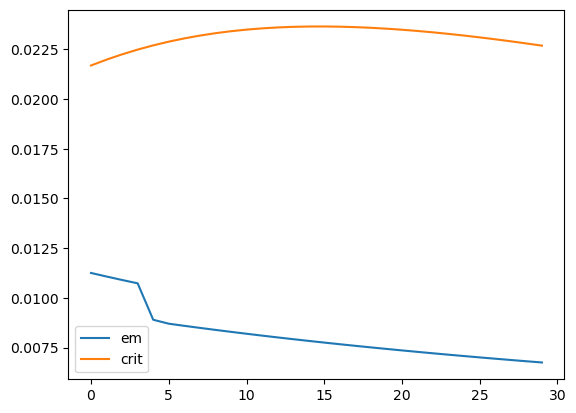

In [6]:
x_points=np.arange(0,30,1)
labels=('em','crit')
def calc2(em=0,crit=0):
    cr=crit/2
    cd=crit/2
    return calc(
            atkp_glidedreams_4pcs(1),
            substat_values_avg[EnumStats.em]*em+em_nahida+
                em_weapon1+em_weapon1_effect1(1)+
                em_weapon1_effect2+
                em_glidedreams_2pcs+
                em_glidedreams_4pcs(2)+100+187,
            substat_values_avg[EnumStats.crit_rate]*cr,
            substat_values_avg[EnumStats.crit_dmg]*cd
        )
    
em_curve=np.fromiter(
    map(
        lambda x: calc2(em=x+1)[0]/calc2(em=x)[0]-1,
        x_points
    ),
    dtype=float
)
crit_curve=np.fromiter(
    map(
        lambda x: calc2(crit=x+1)[0]/calc2(crit=x)[0]-1,
        x_points
    ),
    dtype=float
)
plt.plot(em_curve,label='em')
plt.plot(crit_curve,label='crit')
plt.legend()


In [7]:
reaction_catalyze(EnumCatalyzeReaction.spread,900)

5684.642857142857